## <center>Boston Crime Forecasting (June 2015- September 2018)
### <center>Anil Abraham 2023

#### <center>The goal of this project is to use machine learning techniques to forecast crime in Boston. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

### Brief explanation of each column:
<ul>
<li>INCIDENT_NUMBER - File number</li>
<li>OFFENSE_CODE - Code of specific crime</li>
<li>OFFENSE_CODE_GROUP - Name of crime</li>
<li>OFFENSE_DESCRIPTION - Detailed information about crime</li>
<li>DISTRICT - Boston neighbourhood</li>
<li>REPORTING_AREA - Area defined by Boston PD</li>
<li>SHOOTING - 'Y' represents a shooting occurence</li>
<li>OCCURRED_ON_DATE/YEAR/MONTH/DAY_OF_WEEK/HOUR - Date of crime</li>
<li>UCR_PART - Severity of the crime (highest is 1)</li>
<li>STREET/Lat/Long/Location - Location</li>
</ul>

### <u>Importing libraries</u>

In [163]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
#pd.set_option('display.max_rows', None)

### <u>Loading dataset</u>

In [164]:
df = pd.read_csv('crime.csv', encoding='latin') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

INCIDENT_NUMBER
OFFENSE_CODE
OFFENSE_CODE_GROUP
OFFENSE_DESCRIPTION
DISTRICT
REPORTING_AREA
SHOOTING
OCCURRED_ON_DATE
YEAR
MONTH
DAY_OF_WEEK
HOUR
UCR_PART
STREET
Lat
Long
Location


(319073, 17)

### <u>Data preprocessing</u>

#### Only certain columns are of interest to us, so let's drop the rest.

In [165]:
df.drop(['Location', 'OFFENSE_CODE', 'DISTRICT', 'REPORTING_AREA'], inplace=True, axis=1)

#### Check for null values

In [166]:
print(f'Null values found\n{df.isna().sum()}') #Check for null values

Null values found
INCIDENT_NUMBER             0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
dtype: int64


#### Fill null values

In [167]:
df['SHOOTING'].fillna('N', inplace=True) #Null shootings should be replaced with 'N'

df.loc[df['STREET'].isna(), ('STREET')] = 'Unknown' #Null STREET should be replaced with unknown
df.loc[df['Lat'].isna(), ('STREET')] = 'Unknown'
df.loc[df['Lat'].isna(), ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'].isna(), ('Long')] = -71.17

df.loc[df['Lat'] == -1, ('STREET')] = 'Unknown'
df.loc[df['Lat'] == -1, ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'] == -1, ('Long')] = -71.17

df.loc[df['UCR_PART'].isna(), ('UCR_PART')] = 'Other' #Replace all null UCR_PART with Other

#### Check for duplicates

In [168]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True) #Drop all duplicates
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
24

After checking for duplicates
0


#### Check for duplicate INCIDENT_NUMBER

In [169]:
df[df['INCIDENT_NUMBER'] == 'I152030570-00'] #One such example of an INCIDENT_NUMBER being repeated

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
318742,I152030570-00,Warrant Arrests,WARRANT ARREST,N,2016-10-29 08:25:00,2016,10,Saturday,8,Part Three,W WALNUT PARK,42.317207,-71.098799
318743,I152030570-00,Aggravated Assault,ASSAULT & BATTERY D/W - OTHER,N,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799
318744,I152030570-00,Aggravated Assault,"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",N,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799


##### Cases can have multiple crimes committed per incident, such as the one above. All the crimes belong to the same case, therefore it isn't a duplicate

#### Convert categories

In [170]:
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'],  #Convert to category to save memory
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

#### Convert OCCURED_ON_DATE to pandas datetime object, and convert index to DatetimeIndex

In [171]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE']) #Convert this column to pandas datatype 'datetime'
df.index = pd.DatetimeIndex(df['OCCURRED_ON_DATE']) #Converting index to a DatetimeIndex instead
df.drop(['OCCURRED_ON_DATE'], axis=1, inplace=True) #Drop the OCCURED_ON_DATE column

#### What are the datatypes used?

In [172]:
df.dtypes

INCIDENT_NUMBER          object
OFFENSE_CODE_GROUP       object
OFFENSE_DESCRIPTION      object
SHOOTING                 object
YEAR                      int64
MONTH                     int64
DAY_OF_WEEK            category
HOUR                      int64
UCR_PART                 object
STREET                   object
Lat                     float64
Long                    float64
dtype: object

#### High-level stats of the Boston dataframe

In [173]:
df.describe()

,YEAR,MONTH,HOUR,Lat,Long
count,319049.000000,319049.000000,319049.000000,319049.000000,319049.000000
mean,2016.560676,6.609621,13.118161,42.321498,-71.088516
std,0.996313,3.273682,6.294262,0.030977,0.035922
min,2015.000000,1.000000,0.000000,42.232413,-71.178674
25%,2016.000000,4.000000,9.000000,42.299442,-71.104292
50%,2017.000000,7.000000,14.000000,42.321060,-71.079725
75%,2017.000000,9.000000,18.000000,42.347174,-71.063289
max,2018.000000,12.000000,23.000000,42.395042,-70.963676


#### Let's look at the first and last 3 records of the dataset

In [174]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
OCCURRED_ON_DATE,,,,,,,,,,,,
2015-06-15 00:00:00,I162013546,Property Lost,PROPERTY - LOST,N,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813
2015-06-15 00:00:00,I152051083,Search Warrants,SEARCH WARRANT,N,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247
2015-06-15 00:00:00,I152049897,Property Lost,PROPERTY - LOST,N,2015,6,Monday,0,Part Three,WASHINGTON ST,42.328663,-71.085634
2018-09-03 21:25:00,I182070933,Auto Theft,AUTO THEFT,N,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733
2018-09-03 21:16:00,I182070940,Investigate Property,INVESTIGATE PROPERTY,N,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664
2018-09-03 21:09:00,I182070936,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,N,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590


#### Crimes types grouped by UCR_PART

In [175]:
for i, g in df.groupby(['UCR_PART'], observed=True)['OFFENSE_CODE_GROUP'].unique().items():
    print(i, "\n", g, '\n') #List all crimes grouped by their UCR_PART

Other 
 ['Arson' 'License Plate Related Incidents' 'Auto Theft Recovery'
 'HOME INVASION' 'Other' 'Manslaughter' 'INVESTIGATE PERSON'
 'HUMAN TRAFFICKING' 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'
 'Burglary - No Property Taken'] 

Part One 
 ['Larceny' 'Auto Theft' 'Robbery' 'Larceny From Motor Vehicle'
 'Residential Burglary' 'Aggravated Assault' 'Other Burglary'
 'Commercial Burglary' 'Homicide'] 

Part Three 
 ['Towed' 'Investigate Property' 'Motor Vehicle Accident Response'
 'Verbal Disputes' 'Fire Related Reports' 'Property Lost'
 'Medical Assistance' 'Assembly or Gathering Violations' 'Property Found'
 'Police Service Incidents' 'Warrant Arrests' 'Other'
 'Property Related Damage' 'Missing Person Reported' 'Investigate Person'
 'License Plate Related Incidents' 'Harbor Related Incidents'
 'Firearm Discovery' 'Landlord/Tenant Disputes' 'Missing Person Located'
 'Service' 'Search Warrants' 'License Violation' 'Explosives' 'Aircraft'
 'Prisoner Related Incidents'] 

Part Two 
 ['

##### Part One crimes are the most severe, including crimes such as homicide, aggravated assault, and auto theft. Part three crimes are the least severe, including crimes such as person investigation and license violations.

### <u>Exploratory Data Analysis</u>

#### Seasonality analysis

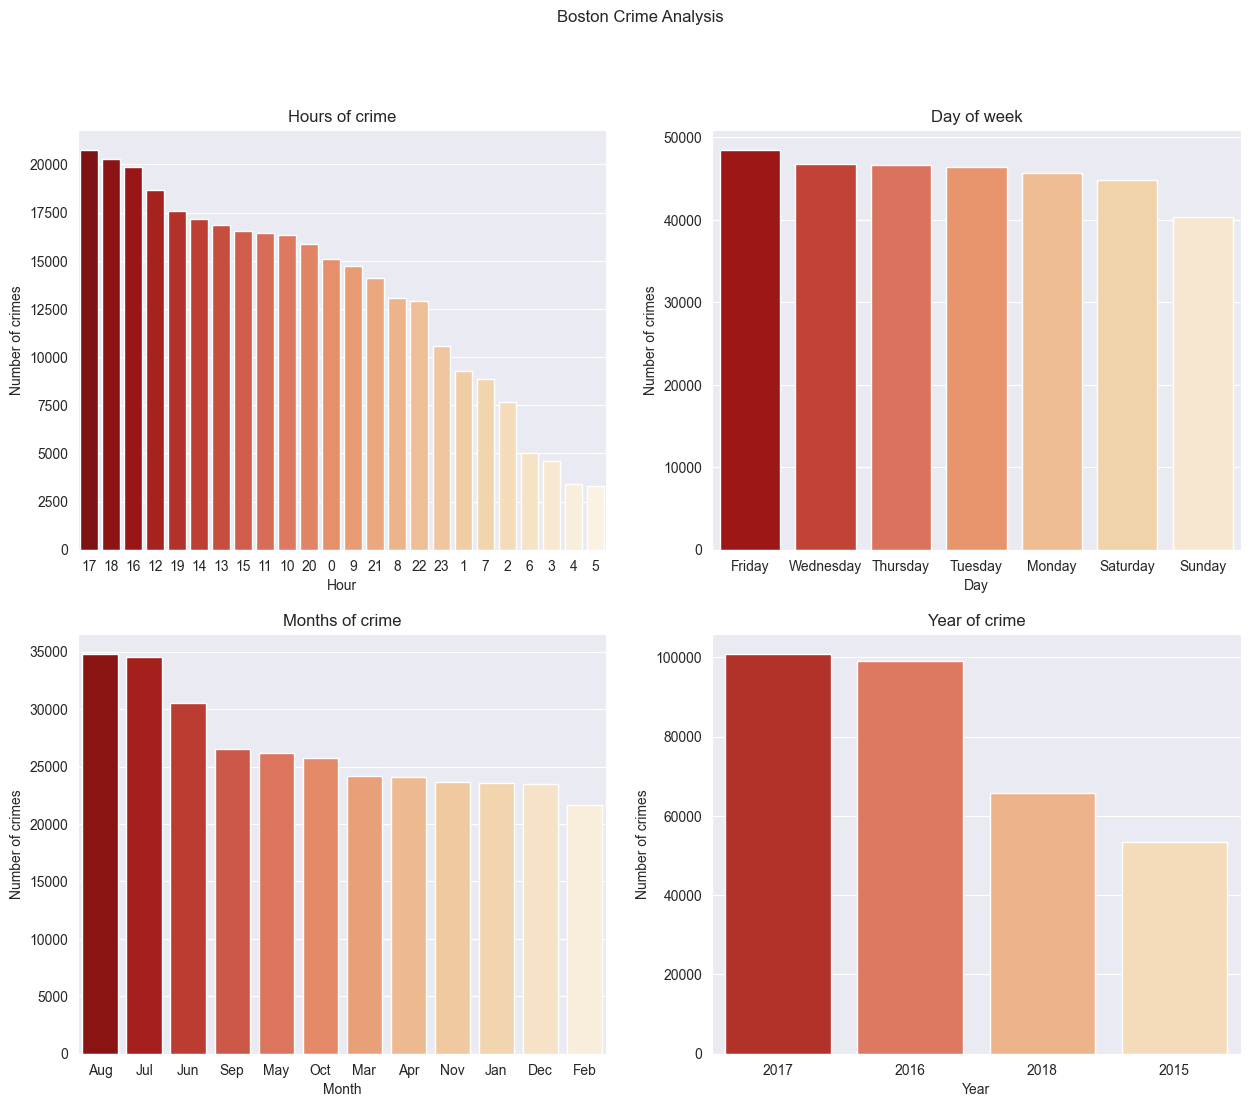

In [183]:
import calendar

df_hours = df.groupby(['HOUR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per HOUR in descending order
df_week = df.groupby(['DAY_OF_WEEK'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per WEEK in descending order
df_month = df.groupby(['MONTH'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per MONTH in descending order
df_year = df.groupby(['YEAR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per YEAR in descending order

df_month = df_month.reset_index()
df_month['MONTH'] = df_month['MONTH'].apply(lambda x: calendar.month_abbr[x]) #Convert number representation of month (8) to string (August)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0]) #Using barplots to visualise the grouped data
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(data=df_month, x='MONTH', y='INCIDENT_NUMBER', palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Hours of crime')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Day of week')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Months of crime')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Year of crime')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Boston Crime Analysis') #Main title
plt.show()

##### The above EDA suggests that most crimes in Boston from 2015-2018 took place between 4pm-6pm, with most crimes occurring on Fridays. The data suggests that most crimes in Boston took place in August and July, and that the years 2018 and 2015 saw a reduction in crime. This cannot be assumed to be true, as this crime dataset recorded data from June 2015 to September 2018, meaning we have a full years worth of data for 2017 and 2016 and half a years worth of data for 2018 and 2015. Hence, we are missing data from Jan 2015 - May 2015 and October 2018 - Dec 2018.

#### Analysis of crimes

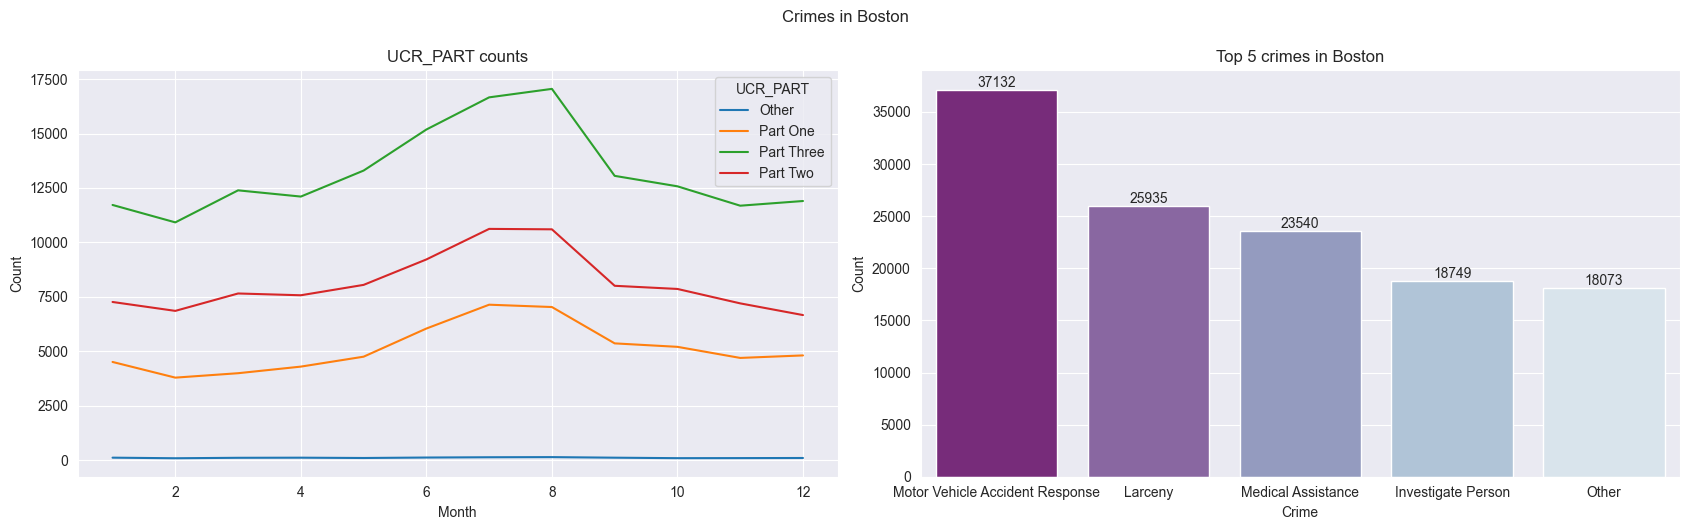

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

df_time = df.groupby(['UCR_PART', df.index.month], observed=True)['INCIDENT_NUMBER'].count().reset_index(name="Count") #Number of crimes committed over the years, according to their UCR_PART category
df_top5 = df.groupby(['OFFENSE_CODE_GROUP'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)[:5] #The top 5 crimes committed

ax = sns.lineplot(df_time, x='OCCURRED_ON_DATE', y='Count', hue='UCR_PART', ax=axs[0]) #Line plot of grouped data
ax1 = sns.barplot(x=df_top5.index, y=df_top5.values, order=df_top5.index, ax=axs[1], palette="BuPu_r") #Bar plot of grouped data

for i in ax1.containers:
    ax1.bar_label(i,) #Display the value above the barplot
    
ax.set_title('UCR_PART counts')
ax1.set_title('Top 5 crimes in Boston')

ax.set_xlabel('Month')
ax.set_ylabel('Count')

ax1.set_xlabel('Crime')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.suptitle("Crimes in Boston", y=1.05) #Add a small margin between the main title and the graphs
plt.show()

##### Most crimes taking place in Boston between 2015 and 2018 were classified as Part 3 crimes, which include less severe crimes such as towing and license violations. Crimes are peaking in June, July, and August. The top 5 crimes in Boston for these years were: Motor vehicle accident responses, larceny, medical assistance crimes, investigate person, and other.

#### <mark>Crime trends in Boston (2015-2018)

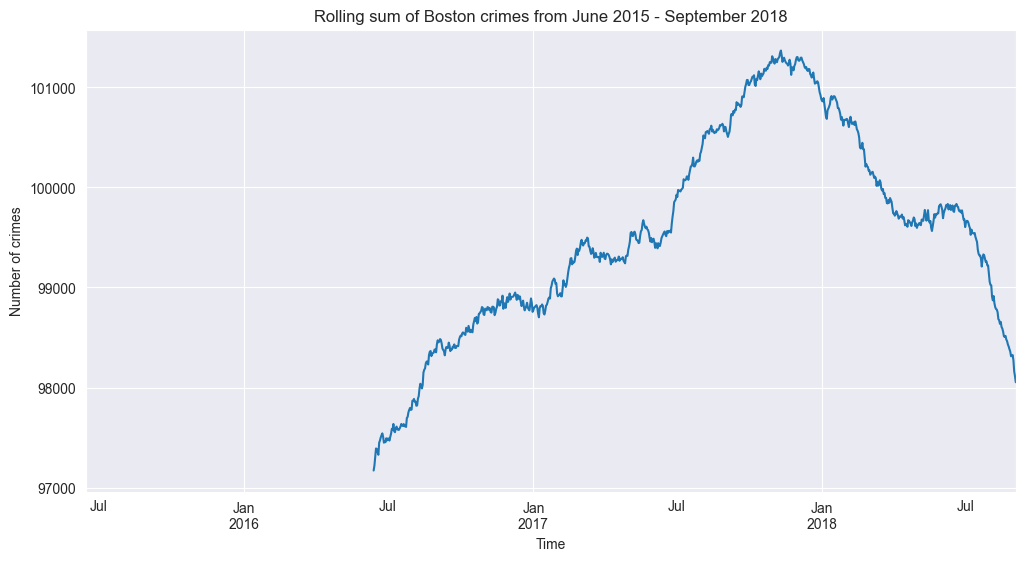

In [102]:
plt.figure(figsize=(12,6))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of Boston crimes from June 2015 - September 2018')
plt.ylabel('Number of crimes')
plt.xlabel('Time')
plt.show()

##### Work in progress...

#### Interactive heatmap of crimes in Boston

In [103]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step #Grouping Latitude/longitude per 0.01 step so as to identify hotspots.
heatmap = df.copy()
heatmap["Lat"] = to_bin(df["Lat"])
heatmap["Long"] = to_bin(df["Long"])
heatmap = heatmap.groupby(["Lat", "Long", "STREET"]).count()['INCIDENT_NUMBER'].reset_index(name='Count')
heatmap = heatmap[heatmap["STREET"] != "Unknown"] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

In [104]:
#Plotting
fig = px.scatter_mapbox(heatmap, lat="Lat", lon="Long", hover_name="STREET", hover_data=["Count"],
                        color="Count", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=11, height=700, size='Count', size_max=35)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### The above interactive map depicts major hotspots as large red circles. These hotspots are identified in the following barplot. The larger/redder the circle, the more crimes were committed in that area. Most hotspots are overlapping due to the latitude/longitude binning, as there may be many streets within a latitude/longitude step (0.01).

#### Barplot of top 10 hotspots in Boston

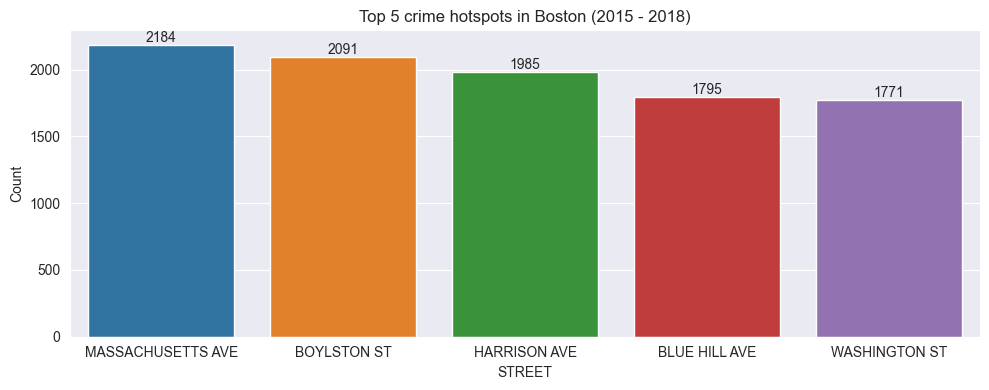

In [105]:
def first_occurrence(series):
    return series.iloc[0] #Return only the first occurence of the lat/long pair so we can sum the count

heatmap_top10 = heatmap.sort_values("Count", ascending=False)[:5].groupby('STREET')\
    .agg({'Lat': first_occurrence, 'Long': first_occurrence, 'Count': 'sum'}).reset_index().sort_values("Count", ascending=False) #The same street occurs for various lat/long coord pairs, therefore we sum them up to get one result.

plt.figure(figsize=(10,4))
ax = sns.barplot(heatmap_top10, x='STREET', y='Count') #Barplot of top 5 crimes

for i in ax.containers:
    ax.bar_label(i,) #Depict crime count over each bar
    
plt.title("Top 5 crime hotspots in Boston (2015 - 2018)")
plt.tight_layout()
plt.show()

##### According to the heatmap above, most crimes in Boston from 2015 - 2018 were committed in Massachussets avenue, Bolyston Street, and Harrison Avenue.

### Static heatmap of Chicago crime hotspots

##### Create geodataframe

In [106]:
heatmap_top10['Size'] = heatmap_top10['Count'] / 5 #Adjusting bubble marker size

geo_df = gpd.GeoDataFrame(heatmap_top10, geometry=[Point(xy) for xy in zip(heatmap_top10['Long'], heatmap_top10['Lat'])]) #Creation of geodf

##### Plot

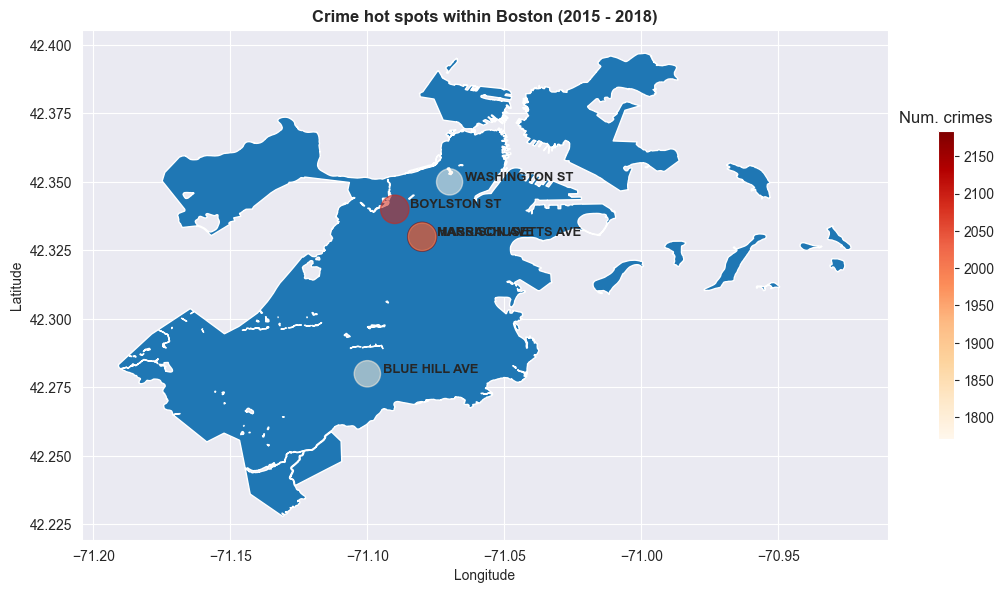

In [107]:
fig, ax = plt.subplots(figsize=(13,10))
map = gpd.read_file("City_of_Boston_Boundary.geojson") #Read in geojson file
map.plot(ax=ax, aspect=1) #Plot geojson file
geo_df.plot(aspect=1, column='Count', markersize='Size', ax=ax, cmap='OrRd', legend=True, alpha=0.55, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same Boston map.

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['STREET']):
    ax.annotate(label, xy=(x, y), xytext=(11,1), textcoords="offset points", weight='bold', fontsize=9.3) #Labelling each hotspot

ax.get_figure().get_axes()[1].set_title("Num. crimes") #Set legend title
plt.title('Crime hot spots within Boston (2015 - 2018)', weight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### <u>Machine Learning</u>

#### Import

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier

#### Data aquisition

In [21]:
X = df.drop(['UCR_PART'], axis=1) #Use all features except UCR_PART
y = df['UCR_PART'] #We will predict UCR_PART

#### Sampling/split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42) #30% test, 70% train

#### Algorithm training

In [136]:
def modelEvaluation(clf, encoder, scoring):
    cv = KFold(n_splits=5)
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"])
    for i in range(len(clf)):  
        start = process_time()  
        name = clf[i].__class__.__name__
        model = make_pipeline(encoder[i], StandardScaler(), clf[i]) if name == 'KNeighborsClassifier' else make_pipeline(encoder[i], clf[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        avg = round(cv_score.mean()*100, 2)
        std = round(cv_score.std()*100,2)
        accuracy = round(accuracy_score(y_test, y_pred)*100,2)
        precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
        recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
        f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
        print(f"{name} {avg}% std: {std} test: {accuracy}")
        print(f"{name} accuracy score: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
        end = process_time()
        print(f"Time taken: {end-start}s\n")
        results = pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})])

    return results.reset_index(drop=True)
  
clf = [RandomForestClassifier(n_jobs=-1, random_state=42),
       DecisionTreeClassifier(random_state=42), 
       CatBoostClassifier(random_state=42, silent=True, allow_writing_files=False),
       AdaBoostClassifier(random_state=42),
       GaussianNB(),
       KNeighborsClassifier()
       ]
encoders = [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ]

#### Cross Validation & Results

In [137]:
d = modelEvaluation(clf, encoders, 'f1_weighted')

RandomForestClassifier 99.99% std: 0.0 test: 99.99
RandomForestClassifier accuracy score: 99.99%
Time taken: 62.9375s

DecisionTreeClassifier 99.14% std: 0.09 test: 98.91
DecisionTreeClassifier accuracy score: 98.91%
Time taken: 5.84375s

CatBoostClassifier 99.99% std: 0.0 test: 100.0
CatBoostClassifier accuracy score: 100.0%
Time taken: 51.875s



c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



AdaBoostClassifier 48.47% std: 0.52 test: 47.23
AdaBoostClassifier accuracy score: 47.23%
Time taken: 30.5s

GaussianNB 94.57% std: 0.27 test: 94.66
GaussianNB accuracy score: 94.66%
Time taken: 4.328125s

KNeighborsClassifier 91.63% std: 0.27 test: 92.19
KNeighborsClassifier accuracy score: 92.19%
Time taken: 185.265625s



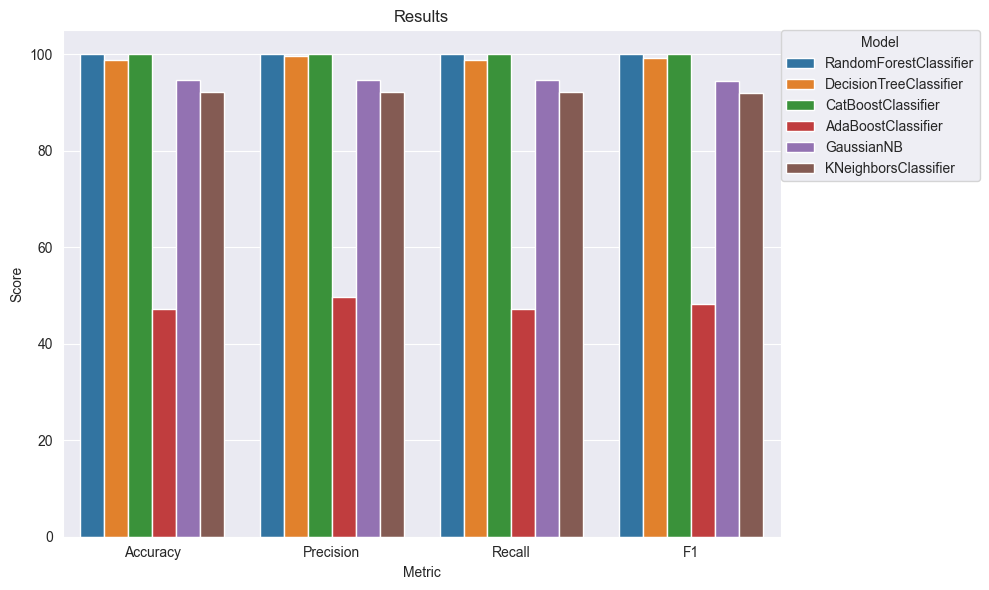

In [138]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

## <center><b>Thanks for reading!</b>